# Time Series Forecasting with PyTorch

- https://github.com/pytorch/examples/tree/main/time_sequence_prediction
- https://d2l.ai/chapter_recurrent-neural-networks/sequence.html
- https://www.sktime.net/en/stable/examples/01a_forecasting_sklearn.html
- https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-3.lstm-post/
- https://kh-kim.gitbooks.io/pytorch-natural-language-understanding/content/neural-machine-translation/teacher-forcing.html
- https://arxiv.org/abs/2210.08959
- https://www.tensorflow.org/tutorials/structured_data/time_series

## Data

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
freq = 0.2
L = 100

times = np.arange(1, L+1)
values = np.sin(freq*times)

df = pd.DataFrame({'time': times, 'value': values})
df

,time,value
0,1,0.198669
1,2,0.389418
2,3,0.564642
3,4,0.717356
4,5,0.841471
...,...,...
95,96,0.343315
96,97,0.523066
97,98,0.681964
98,99,0.813674


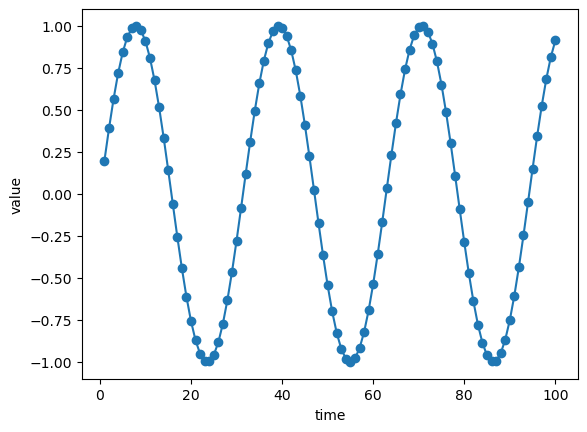

In [ ]:
plt.figure()
plt.plot(df['time'], df['value'], 'o-')
plt.xlabel('time')
plt.ylabel('value')
plt.show()

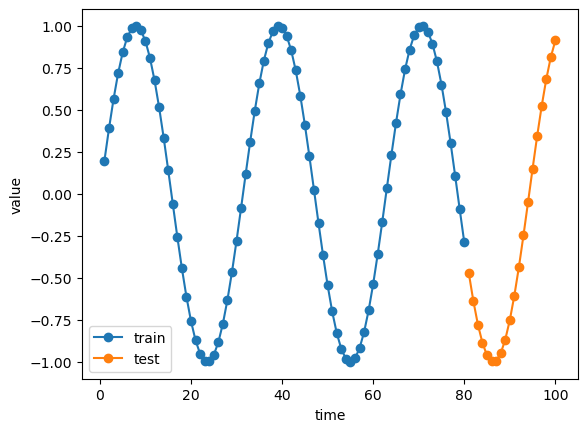

In [ ]:
# test set size (forecasting horizon), we do 20-step-ahead forecasting.
fh = 20

train_df = df[:-fh]
test_df = df[-fh:]

plt.figure()
plt.plot(train_df['time'], train_df['value'], 'o-', label='train')
plt.plot(test_df['time'], test_df['value'], 'o-', label='test')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

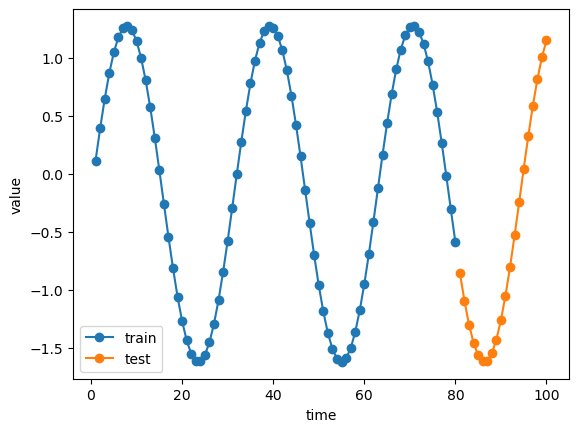

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# We only know the mean and standard deviation of the training data
train_df_scaled = train_df.copy()
train_df_scaled['value'] = scaler.fit_transform(train_df_scaled[['value']].to_numpy())

# We use the mean and standard deviation of the training data to transform the test data
test_df_scaled = test_df.copy()
test_df_scaled['value'] = scaler.transform(test_df_scaled[['value']].to_numpy())

plt.figure()
plt.plot(train_df_scaled['time'], train_df_scaled['value'], 'o-', label='train')
plt.plot(test_df_scaled['time'], test_df_scaled['value'], 'o-', label='test')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

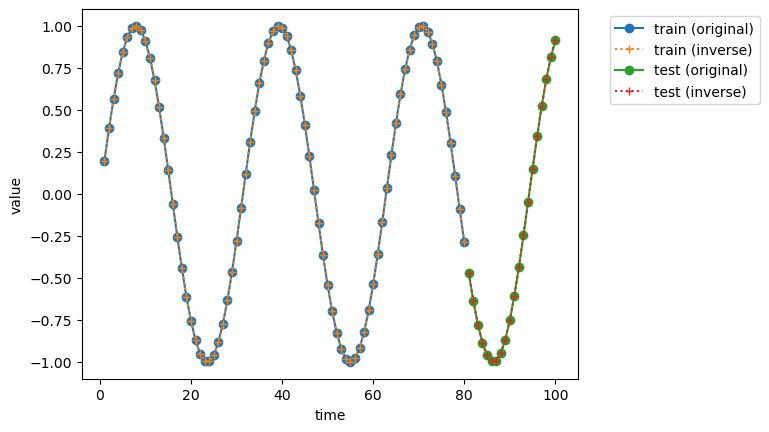

In [ ]:
# inverse transform
train_df_inverse_values = scaler.inverse_transform(train_df_scaled[['value']].to_numpy())
test_df_inverse_values = scaler.inverse_transform(test_df_scaled[['value']].to_numpy())

plt.figure()
plt.plot(train_df['time'], train_df['value'], 'o-', label='train (original)')
plt.plot(train_df['time'], train_df_inverse_values, '+:', label='train (inverse)')
plt.plot(test_df['time'], test_df['value'], 'o-', label='test (original)')
plt.plot(test_df['time'], test_df_inverse_values, '+:', label='test (inverse)')
plt.xlabel('time')
plt.ylabel('value')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

Suppose that the data satisfied a $\tau^{\text{th}}$-order Markov condition.

We predicts $x_t$ using only the past $\tau$ observations.

For time series of length $T$ ($x_1, ..., x_{T}$), we have $T-\tau$ input-output pairs.

| Input | Output |
| ----- | ------ |
| $x_1, x_2, ..., x_{\tau}$ | $x_{\tau+1}$ |
| $x_2, x_3, ..., x_{\tau+1}$ | $x_{\tau+2}$ |
| $\vdots$ | $\vdots$ |
| $x_{T-\tau}, x_{T-\tau+1}, ..., x_{T-1}$ | $x_{T}$ |

We split a time series of length $T=100$ into a sliding-window dataset with window size $\tau=10$. We get 90 input-output pairs.

| Input | Output |
| ----- | ------ |
| $x_1, x_2, ..., x_{10}$ | $x_{11}$ |
| $x_2, x_3, ..., x_{11}$ | $x_{12}$ |
| $\vdots$ | $\vdots$ |
| $x_{89}, x_{90}, ..., x_{98}$ | $x_{99}$ |
| $x_{90}, x_{91}, ..., x_{99}$ | $x_{100}$ |

We split the sliding-window dataset into training and test set (70/20) 

The training set is:

| Input | Output |
| ----- | ------ |
| $x_1, x_2, ..., x_{10}$ | $x_{11}$ |
| $x_2, x_3, ..., x_{11}$ | $x_{12}$ |
| $\vdots$ | $\vdots$ |
| $x_{70}, x_{71}, ..., x_{79}$ | $x_{80}$ |

Then, a **naive** test set is:
| Input | Output |
| ----- | ------ |
| $x_{71}, x_{72}, ..., x_{80}$ | $x_{81}$ |
| $x_{72}, x_{73}, ..., x_{81}$ | $x_{82}$ |
| $\vdots$ | $\vdots$ |
| $x_{90}, x_{91}, ..., x_{99}$ | $x_{100}$ |

However, this naive test set only evaluates the **1-step-ahead prediction**—given the last 10 true values, it predicts the next value. 
$$
\begin{aligned}
\hat{x}_{81} & = f(x_{71}, x_{72}, ..., x_{79}, x_{80}) \\
\hat{x}_{82} & = f(x_{72}, x_{73}, ..., x_{80}, x_{81}) \\
& \vdots \\
\hat{x}_{100} & = f(x_{90}, x_{91}, ..., x_{98} , x_{99}) \\
\end{aligned}
$$
While useful, it does not assess the model's ability to **forecast** multiple steps ahead.

For a true forecast model, the question is: given the sequence $x_1, ..., x_{80}$, can the model predict $x_{81}, ..., x_{100}$? To evaluate the **multi-step-ahead prediction**, a different test setup is required.

$$
\begin{aligned}
\hat{x}_{81} & = f(x_{71}, x_{72}, ..., x_{79}, x_{80}) \\
\hat{x}_{82} & = f(x_{72}, x_{73}, ..., x_{80}, \hat{x}_{81}) \\
& \vdots \\
\hat{x}_{100} & = f(\hat{x}_{90}, \hat{x}_{91}, ..., \hat{x}_{98} , \hat{x}_{99}) \\
\end{aligned}
$$

We plug in our earlier predictions as inputs our model for making subsequent predictions until reaching the desired time step.

In [ ]:
times_train = train_df['time'].to_numpy()
times_test = test_df['time'].to_numpy()
print("train time")
print(times_train)
print("test time")
print(times_test)
print()

window_size = 10

# Create sliding-window input-output pairs
X_train = []
y_train = []

for i in range(len(train_df_scaled) - window_size):
    X_train.append(train_df_scaled['value'].iloc[i:i+window_size])
    y_train.append(train_df_scaled['value'].iloc[i+window_size])

X_train = np.array(X_train)[..., np.newaxis]
y_train = np.array(y_train)[..., np.newaxis]

print("Train input")
print(X_train.shape)
print(X_train[:2])
print()
print("Train output")
print(y_train.shape)
print(y_train[:2])
print()

# Test data
# X_test = []
# y_test = []

# for i in range(len(test_df) - window_size):
#     X_test.append(test_df['value'].iloc[i:i+window_size])
#     y_test.append(test_df['value'].iloc[i+window_size])

# X_test = np.array(X_test)[..., np.newaxis]
# y_test = np.array(y_test)[..., np.newaxis]

# print("Test input?")
# print(X_test.shape)
# print()
# print("Test output")
# print(y_test.shape)
# print()

y_test = test_df_scaled[['value']].to_numpy()
print("Test output")
print(y_test.shape)

train time
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80]
test time
[ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100]

Train input
(70, 10, 1)
[[[0.11362491]
  [0.38964347]
  [0.64319714]
  [0.86417754]
  [1.04377487]
  [1.17482916]
  [1.25211569]
  [1.27255329]
  [1.23532717]
  [1.14192142]]

 [[0.38964347]
  [0.64319714]
  [0.86417754]
  [1.04377487]
  [1.17482916]
  [1.25211569]
  [1.27255329]
  [1.23532717]
  [1.14192142]
  [0.99605983]]]

Train output
(70, 1)
[[0.99605983]
 [0.80355746]]

Test output
(20, 1)


In [ ]:
# x_{70}, x_{71}, ..., x_{79}
X_train[-1]

array([[ 1.25957891],
       [ 1.27031481],
       [ 1.22347624],
       [ 1.12093051],
       [ 0.96676578],
       [ 0.76712811],
       [ 0.52997644],
       [ 0.26476525],
       [-0.01793233],
       [-0.30684604]])

In [ ]:
# x_{80}
y_train[-1]

array([-0.59045779])

In [ ]:
# x_{71}, x_{72}, ..., x_{80}
X_test = X_train[-1].copy()            # x_{70}, x_{71}, ..., x_{79}
X_test = np.roll(X_test, -1)           # x_{71}, x_{72}, ..., x_{70}
X_test[-1] = y_train[-1].copy()        # x_{71}, x_{72}, ..., x_{80}
X_test

array([[ 1.27031481],
       [ 1.22347624],
       [ 1.12093051],
       [ 0.96676578],
       [ 0.76712811],
       [ 0.52997644],
       [ 0.26476525],
       [-0.01793233],
       [-0.30684604],
       [-0.59045779]])

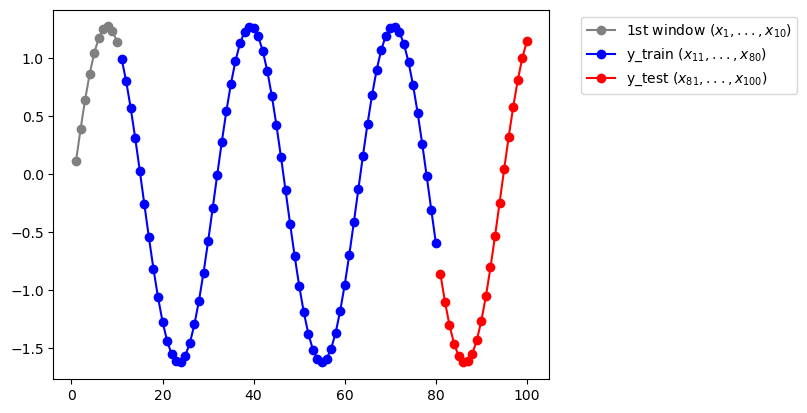

In [ ]:
plt.figure()
plt.plot(times_train[:window_size], X_train[0], 'o-', label='1st window ($x_1, ..., x_{10}$)', color='gray')
plt.plot(times_train[window_size:], y_train, 'o-', label='y_train ($x_{11}, ..., x_{80}$)', color='blue')
plt.plot(times_test, y_test, 'o-', label='y_test ($x_{81}, ..., x_{100}$)', color='red')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

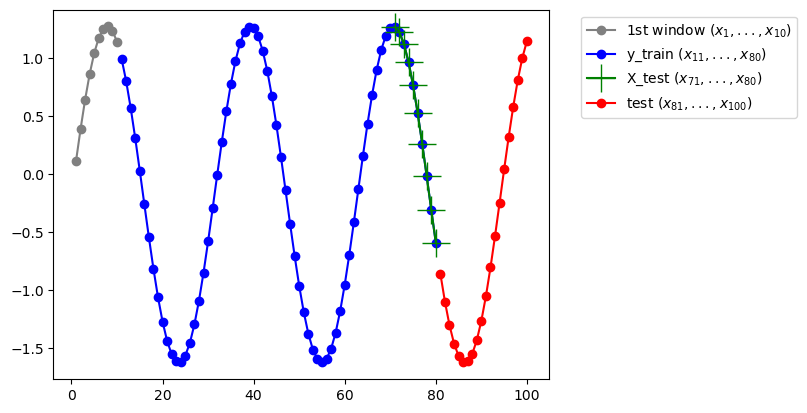

In [ ]:
plt.figure()
plt.plot(times_train[:window_size], X_train[0], 'o-', label='1st window ($x_1, ..., x_{10}$)', color='gray')
plt.plot(times_train[window_size:], y_train, 'o-', label='y_train ($x_{11}, ..., x_{80}$)', color='blue')
plt.plot(times_train[-window_size:], X_test, '+-', label='X_test ($x_{71}, ..., x_{80}$)', color='green', markersize=20)
plt.plot(times_test, y_test, 'o-', label='test ($x_{81}, ..., x_{100}$)', color='red')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70, 10, 1)
(70, 1)
(10, 1)
(20, 1)


## Dataset, DataLoader

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
print("length of train_dataset")
print(len(train_dataset))
print()

sample = train_dataset[0]
print("sample")
print(len(sample))
print(sample[0].shape)
print(sample[1].shape)
print()

train_loader = DataLoader(dataset=train_dataset, batch_size=5, shuffle=True)
batch = next(iter(train_loader))
print("batch")
print(len(batch))
x, y = batch
print(x.shape)  # (batch_size, sequence_length, num_input_features)
print(y.shape)  # (batch_size, num_output_features)

length of train_dataset
70

sample
2
torch.Size([10, 1])
torch.Size([1])

batch
2
torch.Size([5, 10, 1])
torch.Size([5, 1])


idx
0


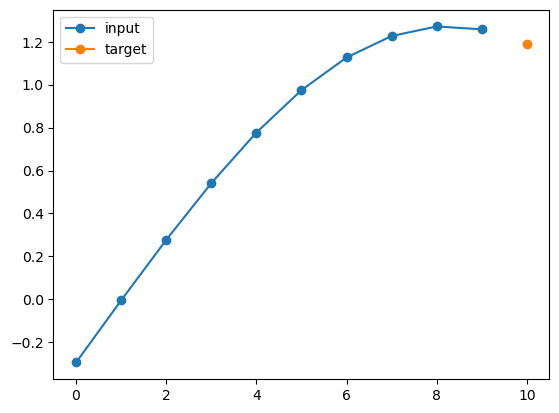

In [ ]:
idx = np.random.randint(0, x.shape[0])
print("idx")
print(idx)
# plt.plot(np.concatenate([x[idx].cpu().numpy().squeeze(), y[idx].cpu().numpy()]), 'o-', label='input');
plt.plot(np.arange(window_size), x[idx].cpu().numpy().squeeze(), 'o-', label='input')
plt.plot([window_size], y[idx].cpu().numpy(), 'o-', label='target')
plt.legend()
plt.show()

In [ ]:
X_test_tensor = torch.from_numpy(X_test[np.newaxis, ...]).float()
X_test_tensor.shape

torch.Size([1, 10, 1])

In [ ]:
y_test_tensor = torch.from_numpy(y_test).float()
y_test_tensor.shape

torch.Size([20, 1])

## Neural Networks

In [ ]:
from torch import nn

$$
x_{11} = \text{Linear}(x_1, x_2, ..., x_{10})
$$

In [ ]:
linear = nn.Linear(in_features=10, out_features=1)

# Forward pass
output = linear(nn.Flatten(start_dim=1)(x))      # (batch_size, sequence_length*num_input_features)
print("output")
print(output.shape)                              # (batch_size, out_features)

output
torch.Size([5, 1])


$$
(h_1, h_2, ..., h_{10}), (h_{10}) = \text{RNN}(x_1, x_2, ..., x_{10})
$$

In [ ]:
rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True)

# Forward pass
output, hidden = rnn(x)  # (batch_size, sequence_length, num_input_features)
print("output")
print(output.shape)      # (batch_size, sequence_length, hidden_size)
print("hidden")
print(hidden.shape)      # (num_layers, batch_size, hidden_size)

output
torch.Size([5, 10, 32])
hidden
torch.Size([1, 5, 32])


$$
(h_1, h_2, ..., h_{10}), (h_{10}, c_{10})= \text{LSTM}(x_1, x_2, ..., x_{10})
$$

In [ ]:
lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)

# Forward pass
output, hidden = lstm(x)        # (batch_size, sequence_length, num_input_features)
print("output")
print(output.shape)             # (batch_size, sequence_length, hidden_size)
print("hidden")
print(hidden[0].shape)          # (num_layers, batch_size, hidden_size)
print("cell")
print(hidden[1].shape)          # (num_layers, batch_size, hidden_size)

output
torch.Size([5, 10, 32])
hidden
torch.Size([1, 5, 32])
cell
torch.Size([1, 5, 32])


$$
(h_1, h_2, ..., h_{10}), (h_{10}) = \text{GRU}(x_1, x_2, ..., x_{10})
$$

In [ ]:
gru = nn.GRU(input_size=1, hidden_size=32, num_layers=1, batch_first=True)

# Forward pass
output, hidden = gru(x)      # (batch_size, sequence_length, num_input_features)
print("output")
print(output.shape)          # (batch_size, sequence_length, hidden_size)
print("hidden")
print(hidden.shape)          # (num_layers, batch_size, hidden_size)

output
torch.Size([5, 10, 32])
hidden
torch.Size([1, 5, 32])


$$
c_1, c_2, ..., c_{10} = \text{1DCNN}(x_1, x_2, ..., x_{10})
$$

In [ ]:
conv1d = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)

# Forward pass
output = conv1d(x.permute(0, 2, 1))  # (batch_size, num_input_features, sequence_length)
print("output")
print(output.shape)                  # (batch_size, num_output_features, sequence_length)

output
torch.Size([5, 32, 10])


## Baseline

In [ ]:
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class ForecastNaive(nn.Module):
    """ Forecast the last value of the input sequence """
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x[:, -1, :]

In [ ]:
def forward(model):
    # Forward pass
    output = model(x)
    print("output")
    print(output.shape)
    print("y_true")
    print(y.shape)

    # Loss
    print("MSE loss")
    criterion = nn.MSELoss()
    loss = criterion(output, y)
    print(loss)

    # Number of parameters
    print("Number of parameters")
    print(sum(p.numel() for p in model.parameters()))

In [ ]:
forecast_naive = ForecastNaive()
forward(forecast_naive)

output
torch.Size([5, 1])
y_true
torch.Size([5, 1])
MSE loss
tensor(0.0536)
Number of parameters
0


In [ ]:
def predict(model, name):
    model.eval()
    
    predictions = []

    y_true_test = torch.clone(y_test_tensor)         # [x_{81}, x_{82} ..., x_{99}, x_{100}]  #(fh, num_output_features)

    last_window = torch.clone(X_test_tensor)         # [x_{71}, x_{72} ..., x_{79}, x_{80}]   #(1, seq_len, num_input_features)
    for _ in range(fh):
        with torch.no_grad():
            last_window = last_window.to(device)
            y_pred = model(last_window)     # \hat{x}_{81}                           #(1, num_output_features)
        predictions.append(y_pred.detach().cpu())            
        # Update the last window
        last_window = torch.roll(last_window, -1, dims=1)        # [x_{72}, x_{73} ..., x_{80}, x_{71}]
        last_window[:, -1] = y_pred                              # [x_{72}, x_{73} ..., x_{80}, \hat{x}_{81}]
        

    predictions = torch.stack(predictions, dim=1)[0].numpy()
    predictions = scaler.inverse_transform(predictions)
    y_true_test = scaler.inverse_transform(y_true_test.numpy())
    print("predictions")
    print(predictions.shape)
    print("y_true")
    print(y_true_test.shape)
    print("MSE error")
    mse_error = F.mse_loss(torch.from_numpy(predictions), torch.from_numpy(y_true_test))
    print(mse_error)

    # Plot
    plt.figure()
    plt.plot(times_train[:window_size], scaler.inverse_transform(X_train[0]), 'o-', label='1st window ($x_1, ..., x_{10}$)', color='gray')
    plt.plot(times_train[window_size:], scaler.inverse_transform(y_train), 'o-', label='y_train ($x_{11}, ..., x_{80}$)', color='blue')
    plt.plot(times_test, y_true_test, 'o-', label='y_test ($x_{81}, ..., x_{100}$)', color='red')
    plt.plot(times_test, predictions, 'o-', label='predictions ($\hat{x}_{81}, ..., \hat{x}_{100}$)', color='orange', markersize=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'{name} forecasting | MSE: {mse_error:.4g}')
    plt.show()

predictions
(20, 1)
y_true
(20, 1)
MSE error
tensor(0.4111)


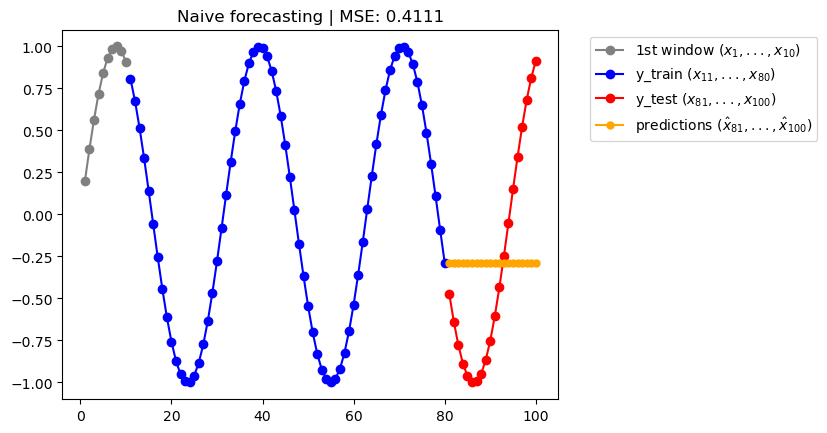

In [ ]:
# Prediction
predict(forecast_naive, "Naive")

## MLP Forecasting

In [ ]:
class ForecastMLP(nn.Module):
    """ Forecasting using a simple MLP """
    def __init__(self, in_features, out_features, hidden_size=32):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(start_dim=1),                                        # (bs, seq_len*num_input_features)
            nn.Linear(in_features=in_features, out_features=hidden_size),   # (bs, hidden_size)
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=out_features)   # (bs, out_features)
        )
    
    def forward(self, x):
        return self.model(x)

In [ ]:
forecast_mlp = ForecastMLP(in_features=10, out_features=1)
forward(forecast_mlp)

output
torch.Size([5, 1])
y_true
torch.Size([5, 1])
MSE loss
tensor(0.7440, grad_fn=<MseLossBackward0>)
Number of parameters
385


In [ ]:
def train(model, lr=0.01, epochs=10, grad_clip=1):
    model.to(device)
    model.train()

    criterion = nn.MSELoss()    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(dataset=train_dataset, batch_size=5, shuffle=True)

    losses = []
    for epoch in range(epochs):
        # tqdm_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}')
        for inputs, y_true in train_loader:
            inputs, y_true = inputs.to(device), y_true.to(device)  

            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred, y_true)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            optimizer.step()

            losses.append(loss.item())
            # tqdm_loader.set_postfix({'loss_per_step': loss.item()})

        loss_per_epoch = sum(losses[-len(train_loader):]) / len(train_loader)
        print('Epoch {:2d}/{:2d}, loss_per_epoch: {:.4g}'.format(epoch + 1, epochs, loss_per_epoch))

    plt.plot(losses);
    return model

Epoch  1/10, loss_per_epoch: 0.3226
Epoch  2/10, loss_per_epoch: 0.03906
Epoch  3/10, loss_per_epoch: 0.01767
Epoch  4/10, loss_per_epoch: 0.00921
Epoch  5/10, loss_per_epoch: 0.002837
Epoch  6/10, loss_per_epoch: 0.000974
Epoch  7/10, loss_per_epoch: 0.0009385
Epoch  8/10, loss_per_epoch: 0.0006072
Epoch  9/10, loss_per_epoch: 0.0004118
Epoch 10/10, loss_per_epoch: 0.000349


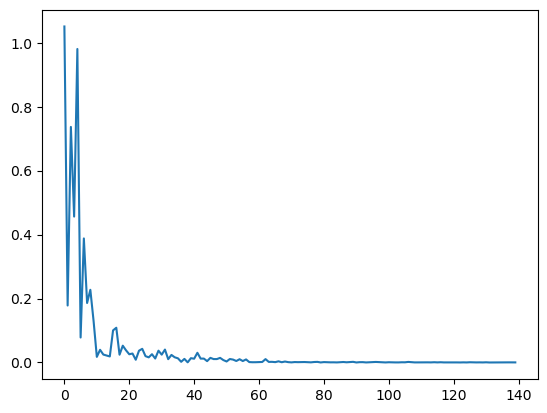

In [ ]:
forecast_mlp = ForecastMLP(in_features=10, out_features=1)
forecast_mlp = train(forecast_mlp)

predictions
(20, 1)
y_true
(20, 1)
MSE error
tensor(0.0004)


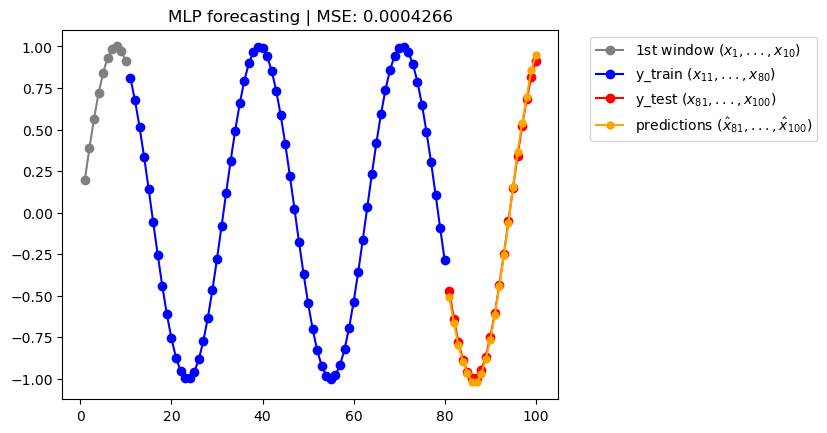

In [ ]:
predict(forecast_mlp, "MLP")

## RNN Forecasting

In [ ]:
class ForecastRNN(nn.Module):
    """ Forecasting using a simple RNN """
    def __init__(self, input_size, output_size, hidden_size, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
    
        self.linear = nn.Linear(
            in_features=hidden_size,
            out_features=output_size
        )
    #   self.linear = nn.Linear(
    #       in_features=hidden_size+1,  # hidden_size + num_input_features
    #       out_features=output_size
    #   )
    
    def forward(self, x):
        _, hidden = self.rnn(x)
        hidden = hidden[-1]                            # (batch_size, hidden_size)
        return self.linear(hidden)                     # (batch_size, output_size)
    #     x_input = x[:, -1, :]                          # (batch_size, num_input_features)
    #     x_input = torch.cat([hidden, x_input], dim=1)  # (batch_size, hidden_size + num_input_features)
    #     return self.linear(x_input)                     # (batch_size, output_size)

In [ ]:
forecast_rnn = ForecastRNN(input_size=1, output_size=1, hidden_size=32)
forward(forecast_rnn)

output
torch.Size([5, 1])
y_true
torch.Size([5, 1])
MSE loss
tensor(0.7594, grad_fn=<MseLossBackward0>)
Number of parameters
1153


Epoch  1/10, loss_per_epoch: 0.3671
Epoch  2/10, loss_per_epoch: 0.02151
Epoch  3/10, loss_per_epoch: 0.009588
Epoch  4/10, loss_per_epoch: 0.004557
Epoch  5/10, loss_per_epoch: 0.002489
Epoch  6/10, loss_per_epoch: 0.002107
Epoch  7/10, loss_per_epoch: 0.002346
Epoch  8/10, loss_per_epoch: 0.001168
Epoch  9/10, loss_per_epoch: 0.0005908
Epoch 10/10, loss_per_epoch: 0.0003121


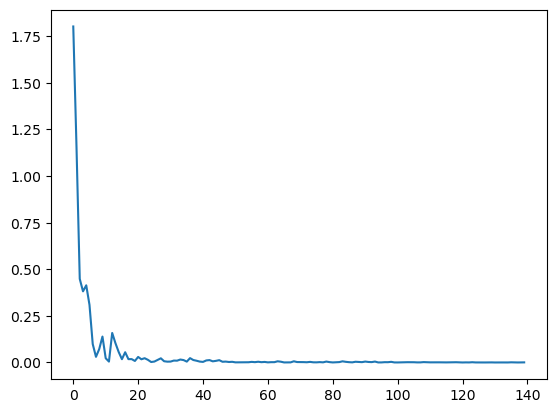

In [ ]:
forecast_rnn = ForecastRNN(input_size=1, output_size=1, hidden_size=32)
forecast_rnn = train(forecast_rnn)

predictions
(20, 1)
y_true
(20, 1)
MSE error
tensor(0.0074)


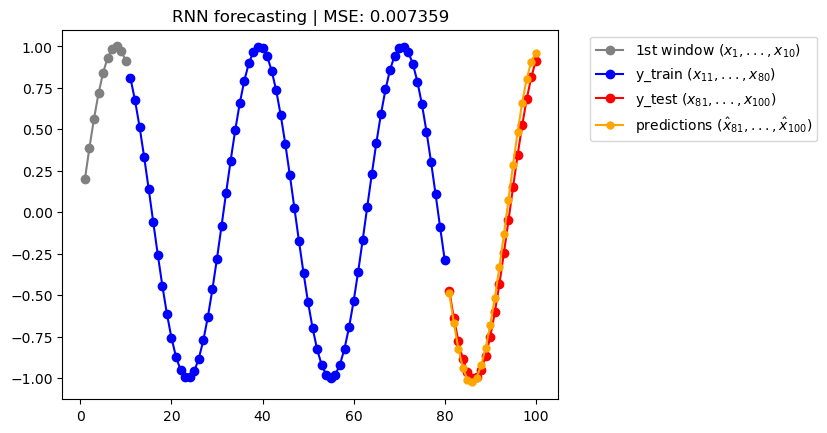

In [ ]:
predict(forecast_rnn, "RNN")

## LSTM Forecasting

In [ ]:
class ForecastLSTM(nn.Module):
    """ Forecasting using a simple LSTM """
    def __init__(self, input_size, output_size, hidden_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.linear = nn.Linear(
            in_features=hidden_size,
            out_features=output_size
        )
    
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = hidden[-1]        # (batch_size, hidden_size)
        return self.linear(hidden) # (batch_size, output_size)

In [ ]:
forecast_lstm = ForecastLSTM(input_size=1, output_size=1, hidden_size=32)
forward(forecast_lstm)

output
torch.Size([5, 1])
y_true
torch.Size([5, 1])
MSE loss
tensor(0.8182, grad_fn=<MseLossBackward0>)
Number of parameters
4513


Epoch  1/10, loss_per_epoch: 0.5687
Epoch  2/10, loss_per_epoch: 0.08169
Epoch  3/10, loss_per_epoch: 0.03326
Epoch  4/10, loss_per_epoch: 0.00939
Epoch  5/10, loss_per_epoch: 0.004447
Epoch  6/10, loss_per_epoch: 0.001947
Epoch  7/10, loss_per_epoch: 0.0007498
Epoch  8/10, loss_per_epoch: 0.0008537
Epoch  9/10, loss_per_epoch: 0.0009016
Epoch 10/10, loss_per_epoch: 0.0007776


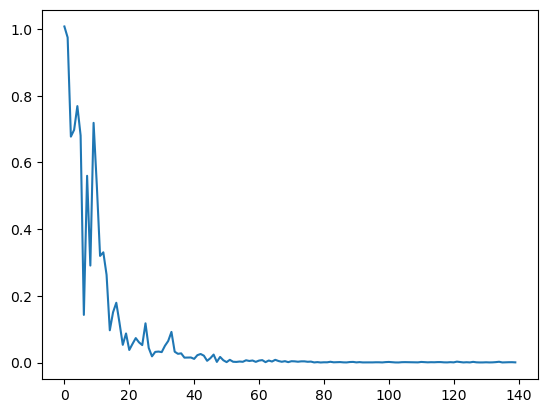

In [ ]:
forecast_lstm = ForecastLSTM(input_size=1, output_size=1, hidden_size=32)
forecast_lstm = train(forecast_lstm)

predictions
(20, 1)
y_true
(20, 1)
MSE error
tensor(0.0028)


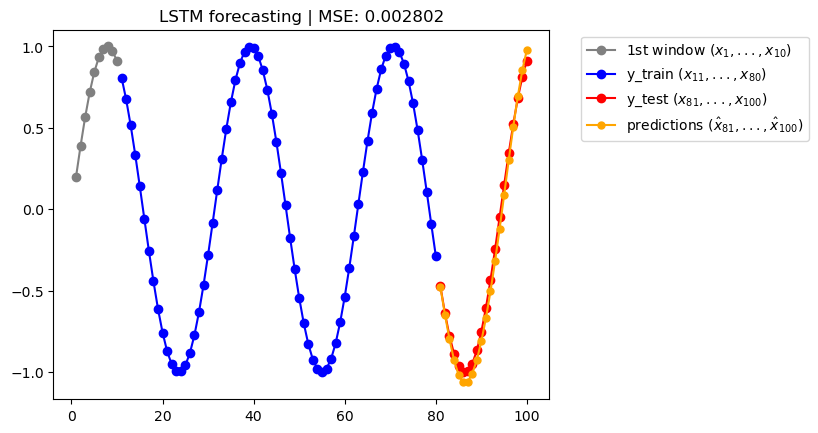

In [ ]:
predict(forecast_lstm, "LSTM")

##

## GRU Forecasting

In [ ]:
class ForecastGRU(nn.Module):
    """ Forecasting using a simple GRU """
    def __init__(self, input_size, output_size, hidden_size, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.linear = nn.Linear(
            in_features=hidden_size,
            out_features=output_size
        )
    
    def forward(self, x):
        _, hidden = self.gru(x)
        hidden = hidden[-1]        # (batch_size, hidden_size)
        return self.linear(hidden) # (batch_size, output_size)

In [ ]:
forecast_gru = ForecastGRU(input_size=1, output_size=1, hidden_size=32)
forward(forecast_gru)

output
torch.Size([5, 1])
y_true
torch.Size([5, 1])
MSE loss
tensor(0.9468, grad_fn=<MseLossBackward0>)
Number of parameters
3393


Epoch  1/10, loss_per_epoch: 0.4995
Epoch  2/10, loss_per_epoch: 0.03224
Epoch  3/10, loss_per_epoch: 0.01715
Epoch  4/10, loss_per_epoch: 0.01093
Epoch  5/10, loss_per_epoch: 0.002469
Epoch  6/10, loss_per_epoch: 0.001018
Epoch  7/10, loss_per_epoch: 0.0005568
Epoch  8/10, loss_per_epoch: 0.0003344
Epoch  9/10, loss_per_epoch: 0.000228
Epoch 10/10, loss_per_epoch: 0.000244


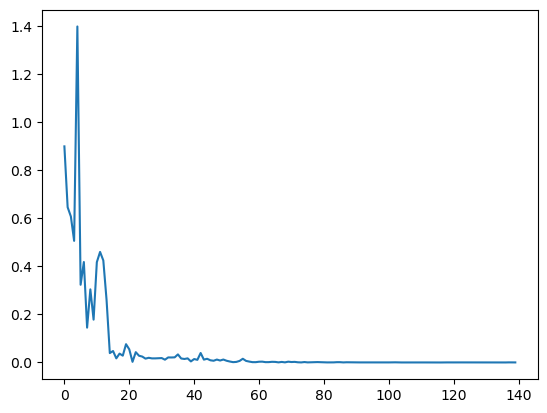

In [ ]:
forecast_gru= ForecastGRU(input_size=1, output_size=1, hidden_size=32)
forecast_gru = train(forecast_gru)

predictions
(20, 1)
y_true
(20, 1)
MSE error
tensor(0.0033)


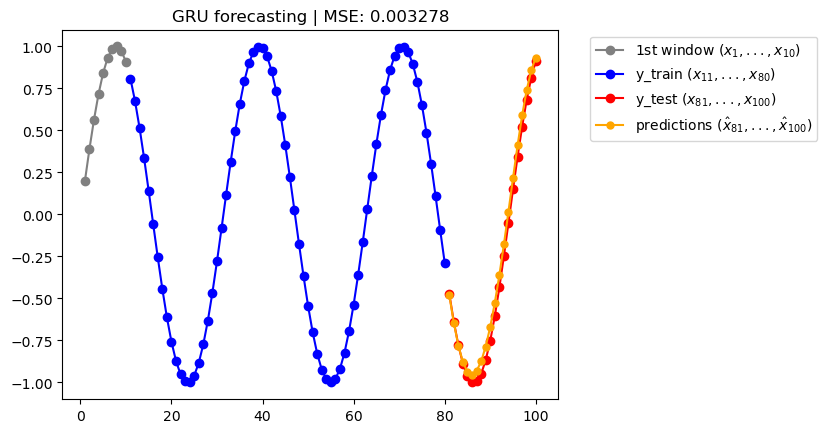

In [ ]:
predict(forecast_gru, "GRU")

## 1D CNN Forecasting

In [ ]:
nn.AdaptiveAvgPool1d(1)(torch.rand(5, 32, 10)).shape

torch.Size([5, 32, 1])

In [ ]:
nn.AvgPool1d(kernel_size=10)(torch.rand(5, 32, 10)).shape

torch.Size([5, 32, 1])

In [ ]:
class Forecast1DCNN(nn.Module):
    """ Forecasting using a simple 1D CNN """
    def __init__(self, input_size, output_size, hidden_size=32):
        super().__init__()
        self.conv1d = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.linear = nn.Linear(
            in_features=hidden_size,
            out_features=output_size
        )
        self.avgpool = nn.AvgPool1d(kernel_size=10)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)   # (batch_size, num_input_features, sequence_length)
        x = self.conv1d(x)       # (batch_size, hidden_size, sequence_length)
        x = self.avgpool(x)      # (batch_size, hidden_size, 1)
        x = x.squeeze(-1)        # (batch_size, hidden_size)
        return self.linear(x)       # (batch_size, output_size)

In [ ]:
forecast_1dcnn = Forecast1DCNN(input_size=1, output_size=1, hidden_size=32)
forward(forecast_1dcnn)

output
torch.Size([5, 1])
y_true
torch.Size([5, 1])
MSE loss
tensor(0.7449, grad_fn=<MseLossBackward0>)
Number of parameters
161


Epoch  1/10, loss_per_epoch: 0.8638
Epoch  2/10, loss_per_epoch: 0.7332
Epoch  3/10, loss_per_epoch: 0.6584
Epoch  4/10, loss_per_epoch: 0.5788
Epoch  5/10, loss_per_epoch: 0.4638
Epoch  6/10, loss_per_epoch: 0.316
Epoch  7/10, loss_per_epoch: 0.1848
Epoch  8/10, loss_per_epoch: 0.08839
Epoch  9/10, loss_per_epoch: 0.02765
Epoch 10/10, loss_per_epoch: 0.005058


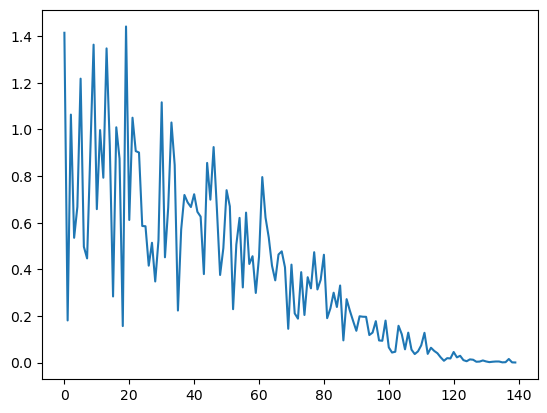

In [ ]:
forecast_1dcnn = Forecast1DCNN(input_size=1, output_size=1, hidden_size=32)
forecast_1dcnn = train(forecast_1dcnn)

predictions
(20, 1)
y_true
(20, 1)
MSE error
tensor(0.0012)


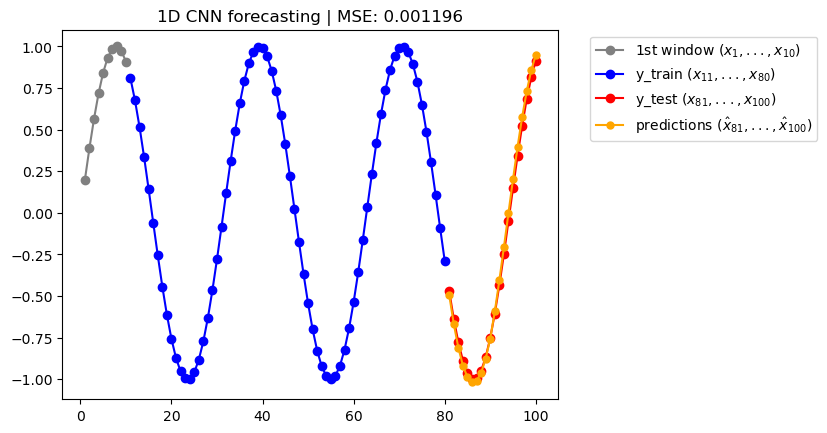

In [ ]:
predict(forecast_1dcnn, "1D CNN")